# Setup

In [1]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [2]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [3]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [4]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [5]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [6]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [7]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [8]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [9]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 181 MMcf
Total peak months intake from pipeline: 12,428 MMcf
Total intake from CaLNG: 1,288 MMcf
---
Total amount paid to pipeline: $18,463,575
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $28,123,575
Savings from using CaLNG: $12,080,986
---
Total cost if average draw daily: $15,342,871


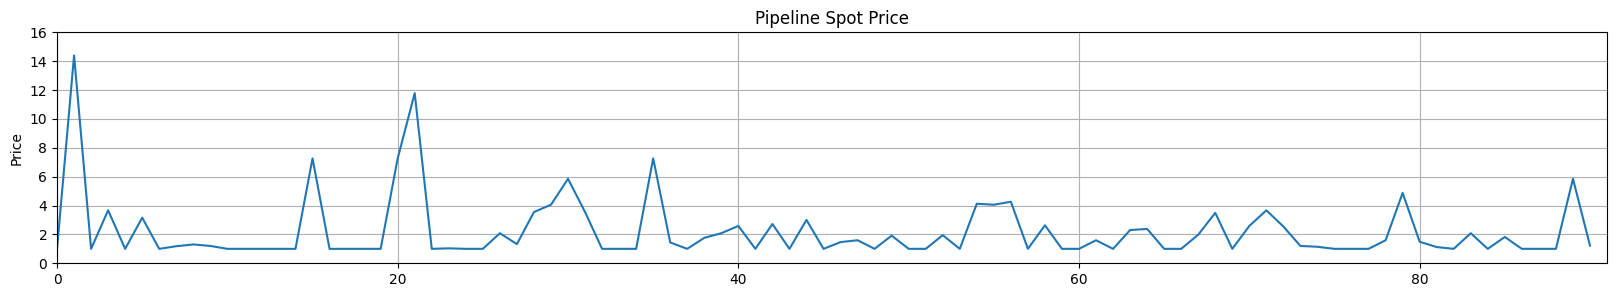

In [10]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_price')
plt.title('Pipeline Spot Price')
plt.axis([0, 91, 0, 16])
plt.grid()
plt.xlabel("")
plt.ylabel("Price")
plt.show()

# Demand

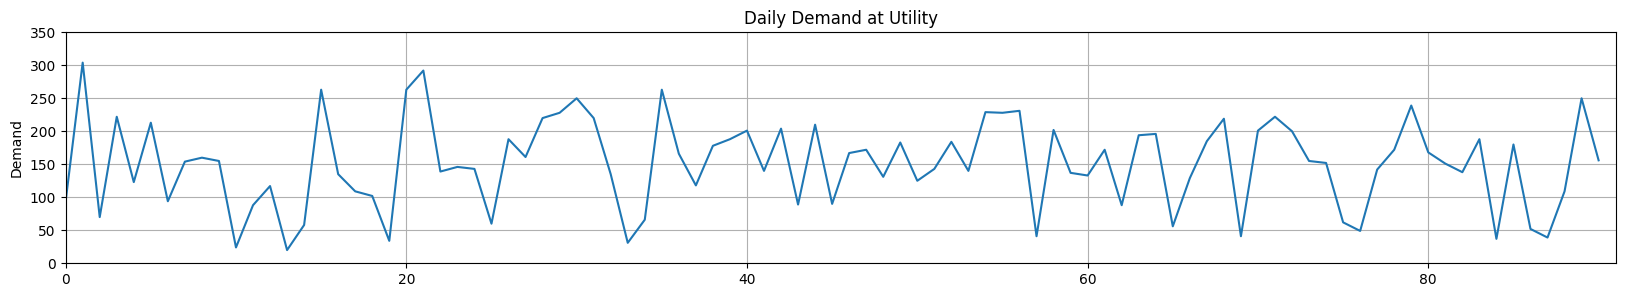

In [11]:
sns.lineplot(data=usage_data, x='price_index', y='Demand')
plt.title('Daily Demand at Utility')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# Intake from Pipeline

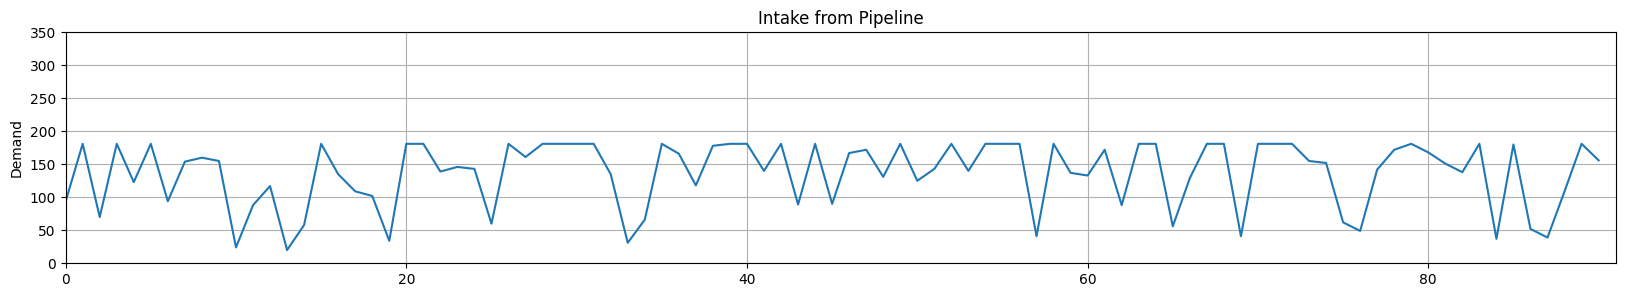

In [12]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_intake')
plt.title('Intake from Pipeline')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# CaLNG Purchase

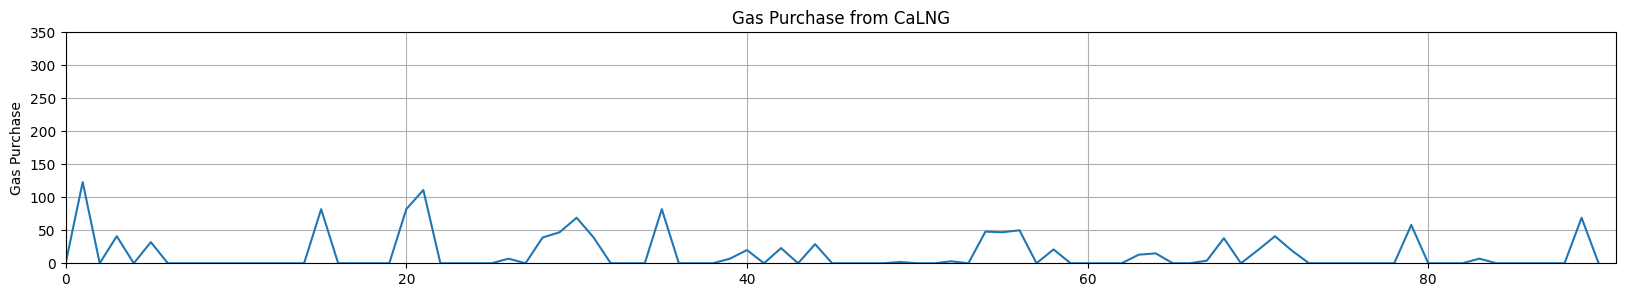

In [13]:
sns.lineplot(data=usage_data, x='price_index', y='purchase_from_calng')
plt.title('Gas Purchase from CaLNG')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Gas Purchase")
plt.show()

# Intake vs. Spot Price

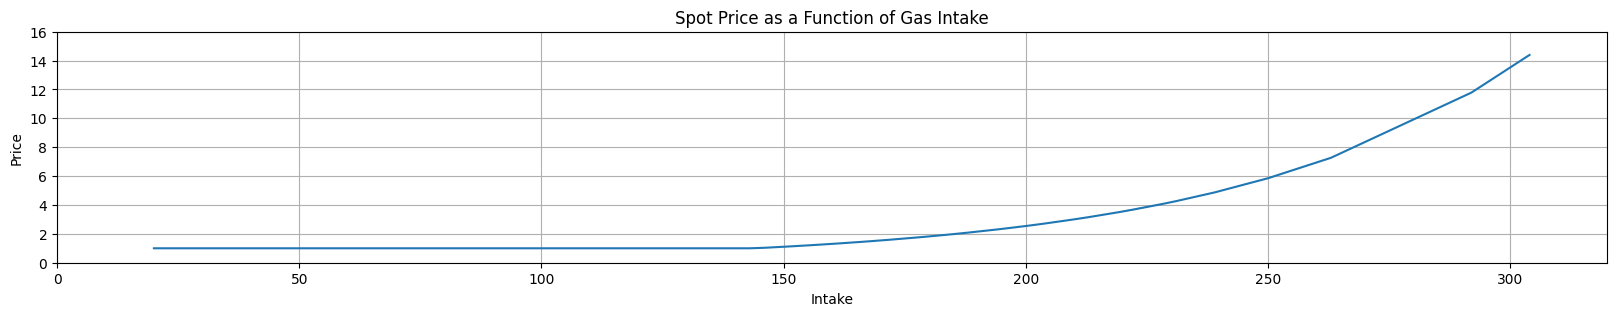

In [14]:
sns.lineplot(data=intake_price_data, x='Intake', y='Price')
plt.title('Spot Price as a Function of Gas Intake')
plt.axis([0, 320, 0, 16])
plt.grid()
plt.show()

# Option

In [15]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [16]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 11,762 MMcf
Total intake from CaLNG: 915 MMcf
---
Total amount paid to pipeline: $16,010,441
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $25,010,441
Savings from using CaLNG: $7,926,909
---
Total cost if average draw daily: $12,677,000


# Option Optimization (Homework)
5000 draws and modified ranges (code has been modified from the original to run faster)

In [34]:
import numpy as np
import pandas as pd

# number of simulation draws per scenario
num_draws = 5000

# decision variables
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range = range(170, 200, 5)

# seed for reproducing results
rng = np.random.default_rng(42)

# generate all demands once
T = len(demand_data)
demands = rng.normal(mean_daily_demand, std_dev_daily_demand, size=(num_draws, T))
demands = np.round(demands)
demands = np.where(demands < 0, 0, demands)

# pipeline-only baseline for savings
pipeline_price_only = np.exp(np.maximum(0, (demands - 144) / 60))
cost_pipeline_only = (demands * pipeline_price_only).sum(axis=1) * 1000

# compute total cost baseline per draw and average
avg_demand_per_draw = demands.mean(axis=1)
avg_price_per_draw = np.exp(np.maximum(0, (avg_demand_per_draw - 144) / 60))
total_average_draw_daily_per_draw = demands.sum(axis=1) * avg_price_per_draw * 1000

rows = []

# loop scenarios
for total_lng in total_lng_range:
    for peak in peak_intake_from_pipeline_range:

        # LNG for each day if capped pipeline at peak
        d_for_lng = np.maximum(demands - peak, 0)

        # LNG allocated up to cap
        cum = np.cumsum(d_for_lng, axis=1)
        capped = np.minimum(cum, total_lng)
        purchase = np.diff(capped, axis=1, prepend=0)

        # pipeline after LNG substitution
        pipeline_intake = demands - purchase
        pipeline_price = np.exp(np.maximum(0, (pipeline_intake - 144) / 60))

        # per-draw totals
        lng_used_per_draw = purchase.sum(axis=1)
        pipeline_used_per_draw = pipeline_intake.sum(axis=1)

        # per-draw costs
        pipeline_cost_per_draw = (pipeline_intake * pipeline_price).sum(axis=1) * 1000

        # pay for contracted total_lng
        calng_cost_per_draw = np.full(num_draws, total_lng * calng_price * 1000.0)

        total_cost_per_draw = pipeline_cost_per_draw + calng_cost_per_draw
        savings_per_draw = cost_pipeline_only - total_cost_per_draw

        rows.append({
            "peak_intake_from_pipeline": float(peak),
            "total_lng_purchase": float(total_lng),
            "total_pipeline_intake": pipeline_used_per_draw.mean(),
            "total_calng_intake": lng_used_per_draw.mean(),
            "total_pipeline_intake_cost": pipeline_cost_per_draw.mean(),
            "total_calng_intake_cost": calng_cost_per_draw.mean(),
            "total_utility_cost": total_cost_per_draw.mean(),
            "total_utility_cost_std": total_cost_per_draw.std(ddof=1),
            "total_savings": savings_per_draw.mean(),
            "total_average_draw_daily": total_average_draw_daily_per_draw.mean()})

df = pd.DataFrame(rows)

# optimal (lowest total utility cost)
best = df.loc[df["total_utility_cost"].idxmin()]
best[["total_lng_purchase", "peak_intake_from_pipeline", "total_utility_cost", "total_utility_cost_std", "total_savings"]]


,26
total_lng_purchase,9.000000e+02
peak_intake_from_pipeline,1.800000e+02
total_utility_cost,2.517835e+07
total_utility_cost_std,3.191594e+06
total_savings,6.461757e+06


In [35]:
# view simulated dataframe
df

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_utility_cost_std,total_savings,total_average_draw_daily
0,170.0,700.0,12415.1970,698.6142,2.177970e+07,5250000.0,2.702970e+07,4.961076e+06,4.610413e+06,1.373119e+07
1,175.0,700.0,12419.7054,694.1058,2.109903e+07,5250000.0,2.634903e+07,4.741764e+06,5.291083e+06,1.373119e+07
2,180.0,700.0,12432.4804,681.3308,2.049426e+07,5250000.0,2.574426e+07,4.348663e+06,5.895853e+06,1.373119e+07
3,185.0,700.0,12459.3394,654.4718,2.009964e+07,5250000.0,2.534964e+07,3.834852e+06,6.290476e+06,1.373119e+07
4,190.0,700.0,12503.9846,609.8266,2.003691e+07,5250000.0,2.528691e+07,3.225963e+06,6.353197e+06,1.373119e+07
...,...,...,...,...,...,...,...,...,...,...
67,175.0,1250.0,12115.4382,998.3730,1.656542e+07,9375000.0,2.594042e+07,1.755316e+06,5.699696e+06,1.373119e+07
68,180.0,1250.0,12228.6504,885.1608,1.722714e+07,9375000.0,2.660214e+07,1.348852e+06,5.037969e+06,1.373119e+07
69,185.0,1250.0,12340.3630,773.4482,1.804067e+07,9375000.0,2.741567e+07,1.220653e+06,4.224442e+06,1.373119e+07
70,190.0,1250.0,12444.1626,669.6486,1.891294e+07,9375000.0,2.828794e+07,1.285205e+06,3.352168e+06,1.373119e+07


In [36]:
# pipeline-only seasonal cost distribution
pipeline_price_only = np.exp(np.maximum(0, (demands - 144) / 60))
pipeline_only_cost_per_draw = (demands * pipeline_price_only).sum(axis=1) * 1000

pipeline_only_cost_per_draw.mean(), pipeline_only_cost_per_draw.std(ddof=1)


(np.float64(31640111.136425853), np.float64(6224638.290516162))

## Cost Plots

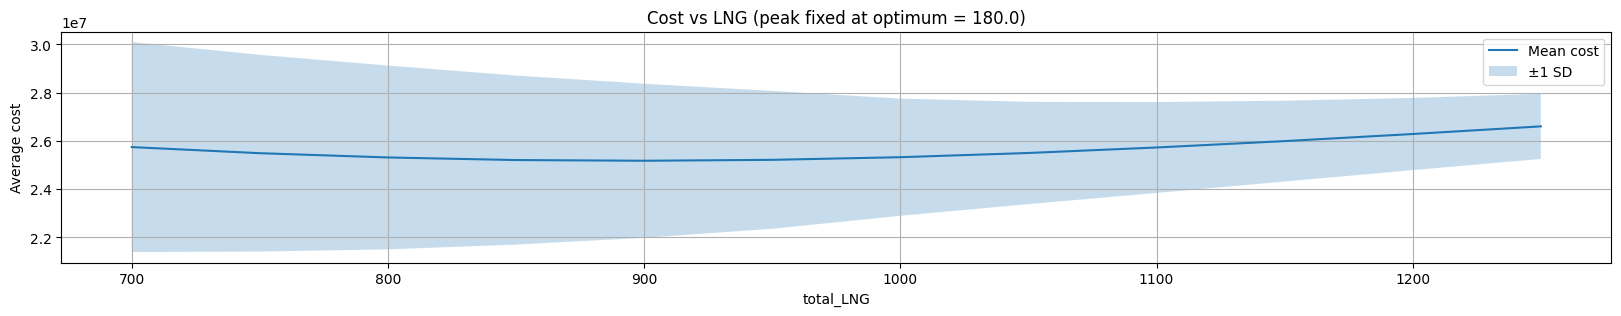

In [37]:
# Plot 1: Average cost (with +/- 1 st dev band) vs. total_LNG, given that peak_intake_from_pipeline is set to its optimum.

best = df.loc[df["total_utility_cost"].idxmin()]
best_total = float(best["total_lng_purchase"])
best_peak  = float(best["peak_intake_from_pipeline"])
best_total, best_peak

import matplotlib.pyplot as plt

d1 = (df[df["peak_intake_from_pipeline"] == best_peak]
    .sort_values("total_lng_purchase"))

x = d1["total_lng_purchase"].to_numpy()
y = d1["total_utility_cost"].to_numpy()
s = d1["total_utility_cost_std"].to_numpy()

plt.figure()
plt.plot(x, y, label="Mean cost")
plt.fill_between(x, y - s, y + s, alpha=0.25, label="±1 SD")

plt.xlabel("total_LNG")
plt.ylabel("Average cost")
plt.title(f"Cost vs LNG (peak fixed at optimum = {best_peak})")
plt.legend()
plt.grid()
plt.show()

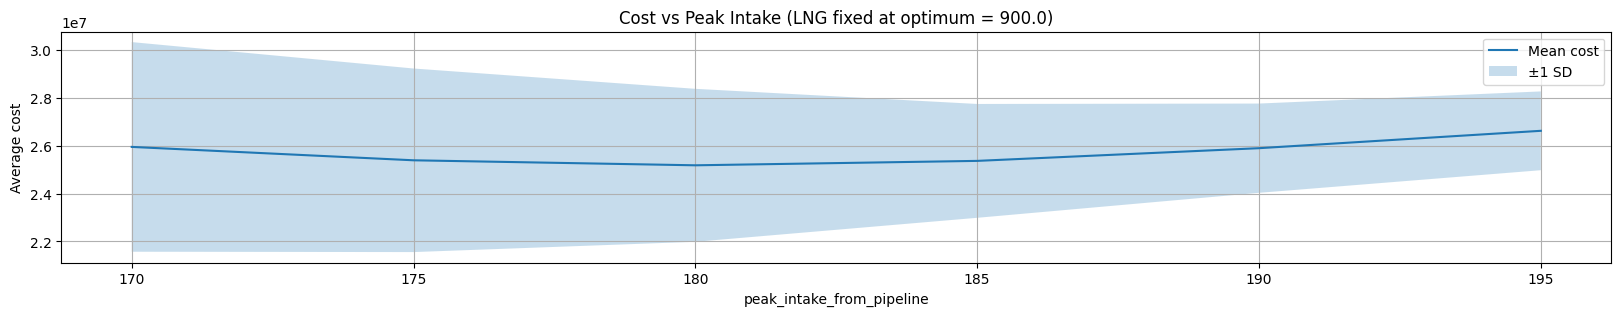

In [38]:
# Plot 2: Average cost (with +/- 1 st dev band) vs. peak_intake_from_pipeline, given that total_LNG is set to its optimum.

d2 = (df[df["total_lng_purchase"] == best_total]
    .sort_values("peak_intake_from_pipeline"))

x = d2["peak_intake_from_pipeline"].to_numpy()
y = d2["total_utility_cost"].to_numpy()
s = d2["total_utility_cost_std"].to_numpy()

plt.figure()
plt.plot(x, y, label="Mean cost")
plt.fill_between(x, y - s, y + s, alpha=0.25, label="±1 SD")

plt.xlabel("peak_intake_from_pipeline")
plt.ylabel("Average cost")
plt.title(f"Cost vs Peak Intake (LNG fixed at optimum = {best_total})")
plt.legend()
plt.grid()
plt.show()

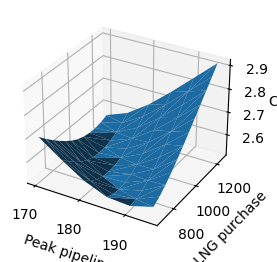

In [23]:
from mpl_toolkits.mplot3d import Axes3D


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 5000

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.plot_trisurf(df["peak_intake_from_pipeline"], df["total_lng_purchase"], df["total_utility_cost"])

ax.set_xlabel('Peak pipeline')
ax.set_ylabel('LNG purchase')
ax.set_zlabel('Cost')

plt.show()
